# Excercise: Recipes & Cuisines
---
 1. Erstelle eine explorative und grafische  Datenanalyse. Erkläre den Dateninhalt durch geeignete Kennzahlen und  Visualisierungen. Relevante Aspekte sind z.B. Umfang, Anzahl Rezepte, Zutaten,  nach Küche, Komplexität der Rezepte nach Küchen, etc.    
 2. Wie schätzt Du die Datenqualität ein? Gibt es  Probleme? Wie würdest Du diese lösen?    
 3. Analysiere die „Ähnlichkeit“ von Rezepten auf  Grundlage der Zutaten (z.B. Desserts, Kuchen und Hauptgerichte)    
 4. Analysiere die Ähnlichkeit von Küchen untereinander    
 5. Erstelle ein Klassifikationsmodell für die cuisine als Zielvariable, also sage aus den Zutaten in einem Rezept die cuisine voraus. Mach gerne geeignete Abkürzungen, um die Klassifikation Ende-zu-Ende einmal zeigen zu können. Wie gut funktioniert die Klassifikation?


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as shc
import seaborn as sns
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
import matplotlib.pyplot as plt
import graphviz
from dtreeviz.trees import dtreeviz # remember to load the package
from wordcloud import WordCloud, get_single_color_func

import auxiliary as aux

sns.set_theme(style="whitegrid", palette="deep")
np.random.seed(0)

### 1. Explorative Analysis

In [3]:
# Load data
df_ingred, df_recipes = aux.load_data()

# Find duplicates and merge
num_dup_ingreds = df_ingred.duplicated().sum()
df_ingred.drop_duplicates(inplace=True)

num_dup_recipes = df_recipes.duplicated().sum()
df_recipes.drop_duplicates(inplace=True)

df_merged = pd.merge(df_recipes, df_ingred, left_on="ID", right_on="ID_recipe")

print(f"Ingredients and recipes contained {num_dup_ingreds} and {num_dup_recipes}, respectively.")

Ingredients and recipes contained 26 and 0, respectively.


#### 1.1 General Observations

In [4]:
# General Observations

# General Size
num_ingredients = len(df_ingred["ingredients"].unique())
num_recipes = len(df_ingred["ID_recipe"].unique())
num_cuisine = len(df_recipes["cuisine"].unique())
print(f"There are {num_ingredients} different ingredients and {num_recipes} different recipes, each belonging to one of {num_cuisine} different cuisines.")

# Average Complexity
mean_num_ingredients = df_ingred.groupby(["ID_recipe"]).count().mean()["ingredients"]
print(f"On average, recipes have {mean_num_ingredients: .2f} different ingredients.")

There are 6714 different ingredients and 39774 different recipes, each belonging to one of 20 different cuisines.
On average, recipes have  10.77 different ingredients.


#### 1.2 Cuisine representation

6 cuisines have more than 2000 recipes, which amount to 68% of total recipes.


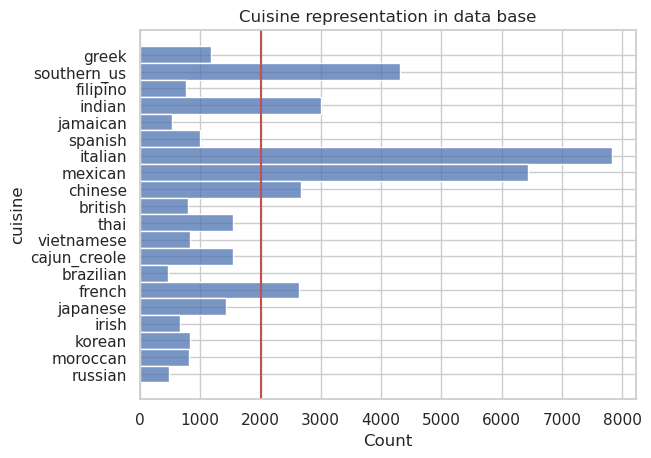

In [5]:
# Occurence of recipes -> look at cuisines with more than 2000 recipes
sns.set_theme(style="whitegrid", palette="deep")
g = sns.histplot(data=df_recipes, y="cuisine")
g.axvline(2000, color='r')
plt.title("Cuisine representation in data base")

# What share to the 6 largest recipes have?
recipe_threshold = 2000
num_cusinises_g2000 = int(df_recipes.groupby("cuisine").count().query(f"ID > {recipe_threshold}").count())
num_recipes_g2000_cuisines = df_recipes.groupby("cuisine").count().query(f"ID > {recipe_threshold}").sum()
share_g2000_cuisines = int(num_recipes_g2000_cuisines) / num_recipes

print(f"{num_cusinises_g2000} cuisines have more than {recipe_threshold} recipes, which amount to {share_g2000_cuisines*100:.0f}% of total recipes.")

### 1.3 Cuisine Complexity

Text(0.5, 1.0, 'Number of ingredients.')

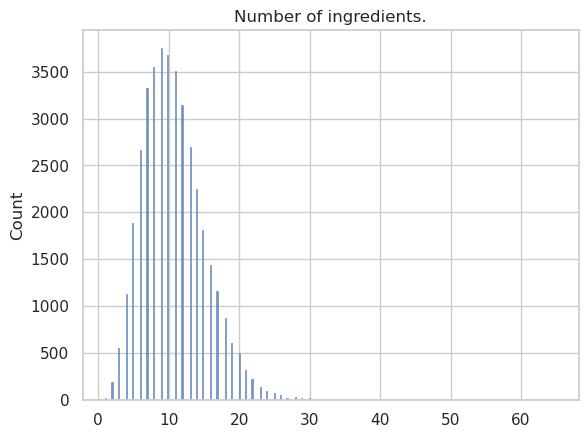

In [6]:
recipe_sizes = df_merged.groupby("ID").size()
g = sns.histplot(data=recipe_sizes)
plt.title("Number of ingredients.")

Text(0.5, 1.0, 'Average number of ingredients')

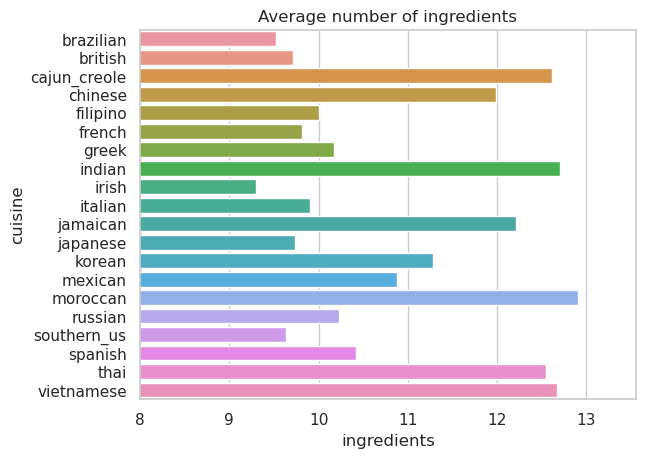

In [7]:
a = df_merged.groupby(["cuisine", "ID"]).count().groupby(["cuisine"])["ingredients"].mean().to_frame()
b = df_merged.groupby(["cuisine", "ID"]).count().groupby(["cuisine"])["ingredients"].std().to_frame()
c = a/b
g = sns.barplot(data=a, y=a.index, x="ingredients").set(xlim=(8,None))
plt.title("Average number of ingredients")

#### 1.2 What are common ingredients?

In [8]:
# most common ingredient
max_ingredient = df_ingred.mode()["ingredients"][0]

ingred_percentage = int(df_ingred.groupby("ingredients").count().max()) / len(df_ingred["ID_recipe"].unique())

print(f"Contained in {ingred_percentage*100:.0f}% of recipes, the most common ingredient is: {max_ingredient}.")

# most common ingredient by cuisine
print("For each cuisine, the most common ingredients is listed below.")
df_merged.groupby("cuisine")["ingredients"].agg(pd.Series.mode).to_frame()

Contained in 45% of recipes, the most common ingredient is: salt.
For each cuisine, the most common ingredients is listed below.


,ingredients
cuisine,
brazilian,salt
british,salt
cajun_creole,salt
chinese,soy sauce
filipino,salt
french,salt
greek,salt
indian,salt
irish,salt


In [9]:
# Deep Dive: N most common ingredients for cuisines recipes
df_merged.groupby(["cuisine", "ingredients"]).count().groupby(["cuisine"])["ID"].nlargest(3).to_frame().droplevel(1)

ID
cuisine      ingredients            
brazilian    salt                194
             onions              133
             olive oil           118
british      salt                407
             all-purpose flour   238
             butter              222
cajun_creole salt                743
             onions              529
             garlic              370
chinese      soy sauce          1363
             sesame oil          915
             salt                907
filipino     salt                421
             garlic              325
             onions              310
french       salt               1203
             sugar               637
             all-purpose flour   593
greek        salt                571
             olive oil           503
             dried oregano       266
indian       salt               1934
             onions             1195
             garam masala        862
irish        salt                376
             all-purpose flour   219
             butter              219
italian      salt               3454
             olive oil          3111
             garlic cloves      1619
jamaican     salt                332
             onions              173
             water               153
japanese     soy sauce           561
             salt                422
             mirin               402
korean       soy sauce           427
             sesame oil          403
             garlic              303
mexican      salt               2720
             onions             1493
             ground cumin       1346
moroccan     salt                413
             olive oil           412
             ground cumin        348
russian      salt                288
             sugar               155
             onions              145
southern_us  salt               2290
             butter             1255
             all-purpose flour  1222
spanish      salt                460
             olive oil           387
             garlic cloves       290
thai         fish sauce          625
             garlic              414
             salt                396
vietnamese   fish sauce          392
             sugar               344
             salt                264

#### 1.5 Largest recipes

In [10]:
# max ingredient size
df_merged.groupby(["ID", "cuisine"])["ingredients"].count().nlargest(5)

ID     cuisine  
3885   italian      65
13430  brazilian    59
13049  mexican      52
2253   indian       49
49282  mexican      49
Name: ingredients, dtype: int64

In [16]:
# max recipe ingredients
df_merged.set_index("ID").loc[13430, "ingredients"]

ID
13430                         marshmallows
13430                           fresh corn
13430                       cheddar cheese
13430                     shredded coconut
13430                                water
13430                                honey
13430                          baking soda
13430                        dijon mustard
13430                       sweet potatoes
13430                      chicken breasts
13430                        vegetable oil
13430                                 salt
13430                       condensed milk
13430                                candy
13430                           canola oil
13430                                 eggs
13430                          brown sugar
13430                       glutinous rice
13430                          white onion
13430                                dashi
13430                    whole wheat flour
13430                            oat flour
13430                                flour
13430   

#### 1.6 One-ingredient recipes

In [17]:
# min_ingredient_size
min_ids = df_merged.groupby(["ID", "cuisine"]).size().reset_index(name='counts').query(f"counts == 1")["ID"]

assert(len(df_merged.set_index("ID").loc[min_ids]["ingredients"]) == len(min_ids))

print(f"There exist {len(min_ids)} single ingredient recipes.")
df_merged.set_index("ID").loc[min_ids].groupby(["ingredients"]).size().reset_index(name='counts')

There exist 22 single ingredient recipes.


,ingredients,counts
0,butter,2
1,cherry tomatoes,1
2,corn tortillas,1
3,cumin seed,1
4,dried rice noodles,1
5,grained,1
6,haricots verts,1
7,jasmine rice,1
8,lemonade concentrate,1
9,phyllo,1


#### 1.7 Longest/ shortest ingredient

In [18]:
# longest ingredient
longest_ingredient = df_ingred["ingredients"].str.len().to_frame().idxmax()
long = df_ingred.loc[longest_ingredient]["ingredients"].iloc[0]

# shortest ingredient
longest_ingredient = df_ingred["ingredients"].str.len().to_frame().idxmin()
short = df_ingred.loc[longest_ingredient]["ingredients"].iloc[0]

print(f"The longest ingredient is: {long}.\n The shortest ingredient is: {short}")

The longest ingredient is: Pillsbury™ Crescent Recipe Creations® refrigerated seamless dough sheet.
 The shortest ingredient is: mi


## 2. Data Issues

#### 2.1 Minor Issues
 - (Some) duplicates: 26 in ingredients
 - Irregularity of user input: spelling and definition of "recipe"

In [19]:
# spelling
df_ingred.query("ingredients == 'grained'")

,ID_recipe,ingredients
141796,29570,grained
240041,41407,grained
391012,33498,grained


In [20]:
# multiple dishes in one
df_merged.set_index("ID").loc[13430].set_index("ingredients").filter(regex ="flour|candy|chicken", axis=0)

,cuisine,ID_recipe
ingredients,,
chicken breasts,brazilian,13430
candy,brazilian,13430
whole wheat flour,brazilian,13430
oat flour,brazilian,13430
flour,brazilian,13430
boneless skinless chicken breasts,brazilian,13430
all-purpose flour,brazilian,13430


In [21]:
# alternatives in single dish
df_merged.set_index("ID").loc[13430].set_index("ingredients").filter(regex ="flour", axis=0)

,cuisine,ID_recipe
ingredients,,
whole wheat flour,brazilian,13430
oat flour,brazilian,13430
flour,brazilian,13430
all-purpose flour,brazilian,13430


#### 2.2 Balance of data
 - 68% of cuisines belong to one of 6 cuisines
 - 20% of all recipes are italian.

6 cuisines have more than 2000 recipes, which amount to 68% of total recipes.


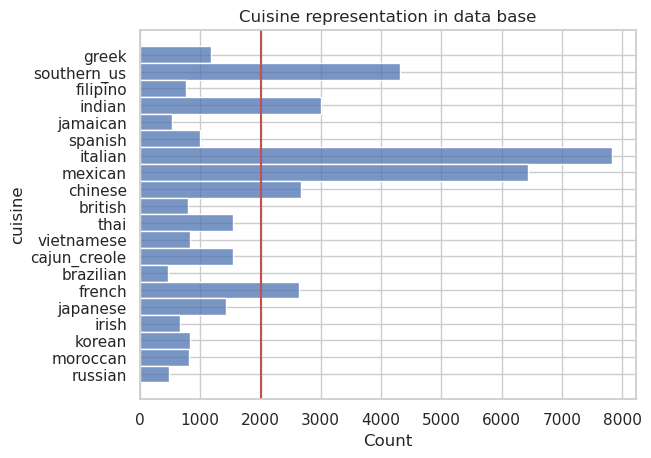

In [22]:
# Occurence of recipes -> look at cuisines with more than 2000 recipes
sns.set_theme(style="whitegrid", palette="deep")
g = sns.histplot(data=df_recipes, y="cuisine")
g.axvline(2000, color='r')
plt.title("Cuisine representation in data base")

# What share to the 6 largest recipes have?
recipe_threshold = 2000
num_cusinises_g2000 = int(df_recipes.groupby("cuisine").count().query(f"ID > {recipe_threshold}").count())
num_recipes_g2000_cuisines = df_recipes.groupby("cuisine").count().query(f"ID > {recipe_threshold}").sum()
share_g2000_cuisines = int(num_recipes_g2000_cuisines) / num_recipes

print(f"{num_cusinises_g2000} cuisines have more than {recipe_threshold} recipes, which amount to {share_g2000_cuisines*100:.0f}% of total recipes.")

#### 2.3 de-facto duplication/terminology of ingredients
influence is complex:
 - if terminology has systematic relationship to cuisine, it can be strong preditcor
    - still renders interpretation of feature influence more complicated
 - if terminology is unsystematically "noisy", it negatively affects classification

Issue: it is difficult to find all of these terminology differences and, hence, ex ante judgmentes on their influence is impossible.

*Potential solutions*: try to aggregate ingredients

##### 2.3.1 Example: Diced Tomatoes

There 11 versions of 'diced tomatoes'.


Text(0.5, 1.0, "Types of 'diced tomatoes'")

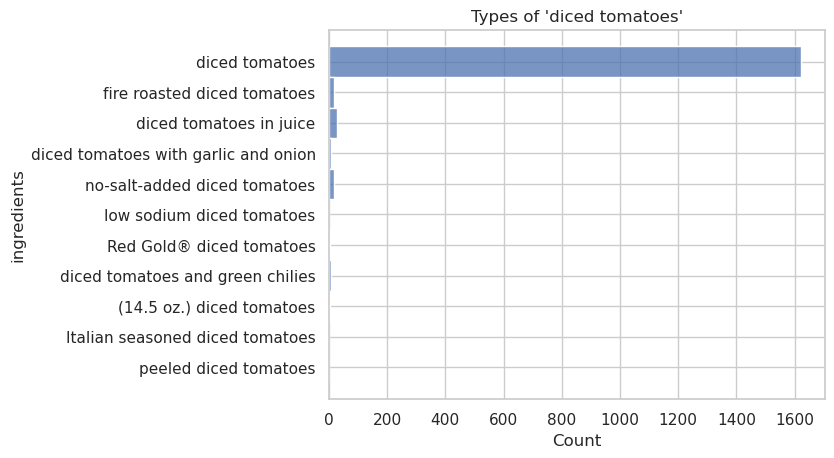

In [23]:
# diced Tomatoes
diced_tomato = df_ingred.set_index("ingredients").filter(regex = "dice(.*)tomato", axis=0).reset_index(level=0)["ingredients"].unique()

print(f"There {diced_tomato.size} versions of 'diced tomatoes'.")
#print(diced_tomato)
a = df_ingred.set_index("ingredients").filter(regex = r"dice(.*)tomato", axis=0).reset_index(level=0)
g = sns.histplot(data=a, y="ingredients")
plt.title("Types of 'diced tomatoes'")

##### 2.3.2 Example: Salt

There 37 versions of 'salt'':



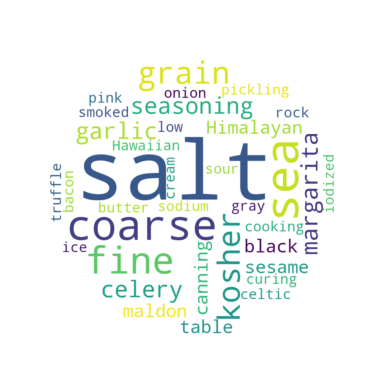

In [24]:
aux.multiple_salts(df_ingred)

## 3. Similarity of recipes

Focussed on similarity based on domain-knowledge.

Example: Identifying cakes.

In [25]:
cake = ["sugar", "flour", "milk"]
pat = "|".join(cake)
cake_recipes = df_ingred.set_index("ingredients").filter(regex=pat, axis=0).reset_index(level=0).groupby("ID_recipe").count().query(f"ingredients >= {len(cake)}").index

# look at cake recipes
df_recipes.set_index("ID").loc[cake_recipes].reset_index(level=0).groupby("cuisine").count().nsmallest(5, columns="ID_recipe")

,ID_recipe
cuisine,
korean,9
moroccan,16
vietnamese,23
brazilian,25
greek,28


## 4. Recipe Classification with Random Forest

In [ ]:
aux.prepare_MCA_based_analysis(df_ingred, df_recipes, split=3)
aux.prepare_sparse_data_analysis(df_ingred, df_recipes, split=3)

#### 4.1 Based on Reduced dimensionality (MCA)

In [26]:
# load data
X_data, y_data = aux.load_MCA_data()

# hold-back some test data
Xtrain, Xtest, y_train, y_test = train_test_split(X_data,y_data, test_size=0.2, random_state=101)

# fit the model under default parameters
model = RandomForestClassifier(n_estimators=50)
model.fit(Xtrain, y_train)
score = model.score(Xtest, y_test)
print(f"The RF prediction accuracy under MCA is: {score:.2f}")

The RF prediction accuracy under MCA is: 0.44


##### 4.1.1 Hypter-parameter tuning

In [28]:
# param grid to search
param_grid = aux.RF_MCA_parameter_grid()
param_grid

{'n_estimators': [10, 17, 25, 33, 41, 48, 56, 64, 72, 80],
 'max_features': ['sqrt'],
 'max_depth': [2, 4],
 'min_samples_split': [2, 5],
 'min_samples_leaf': [1, 2],
 'bootstrap': [True, False]}

In [27]:
rf_grid = GridSearchCV(estimator=model, param_grid = param_grid, cv=5, verbose=2, n_jobs=4)
rf_grid.fit(Xtrain,y_train)
score = rf_grid.score(Xtest, y_test)

print(f"The tuned RF prediction accuracy under MCA is: {score:.2f}")

Fitting 5 folds for each of 160 candidates, totalling 800 fits
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=17; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=25; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=33; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=41; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=41; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=48; total time=   0.6s

[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=17; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=17; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=25; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=33; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=41; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=48; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_s

[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=17; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=25; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=25; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=33; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=41; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=48; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_s

[CV] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=80; total time=   1.6s
[CV] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=17; total time=   0.4s
[CV] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=17; total time=   0.4s
[CV] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=25; total time=   0.5s
[CV] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=33; total time=   0.6s
[CV] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=41; total time=   0.9s
[CV] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=48; total time=   0.9s
[CV] END bootstrap=True, max_depth=4, max_features=sqrt, min_s

[CV] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=56; total time=   0.9s
[CV] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=56; total time=   0.8s
[CV] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=64; total time=   1.0s
[CV] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=72; total time=   1.1s
[CV] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=80; total time=   1.1s
[CV] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=   0.2s
[CV] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=   0.2s
[CV] END bootstrap=False, max_depth=2, max_features=sqr

[CV] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=48; total time=   0.7s
[CV] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=48; total time=   0.8s
[CV] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=56; total time=   0.9s
[CV] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=64; total time=   1.0s
[CV] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=72; total time=   1.1s
[CV] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=80; total time=   1.2s
[CV] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=80; total time=   1.3s
[CV] END bootstrap=False, max_depth=2, max_features=sqr

The tuned RF prediction accuracy under MCA is: 0.49


#### 4.2 With sparse vectors, but minimum occurence threshold of 21.

In [3]:
# load data
X_data, y_data = aux.load_20_threshold_data()

# hold-back some test data
Xtrain, Xtest, y_train, y_test = train_test_split(X_data,y_data, test_size=0.2, random_state=101)

# fit the model under default parameters
model = RandomForestClassifier(n_estimators=50)
Xtrain, Xtest, y_train, y_test = train_test_split(X_data,y_data, test_size=0.2, random_state=101)
model.fit(Xtrain, y_train)
score = model.score(Xtest, y_test)

print(f"The RF prediction accuracy under sparse features is: {score:.2f}")

The RF prediction accuracy under sparse features is: 0.70


##### 4.2.1 Hypterparameter tuning

In [4]:
param_grid = aux.RF_MCA_parameter_grid()
param_grid["max_depth"] = [None, 10, 20, 30]

rf_random = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=50, cv=3, random_state=42, n_jobs=4)
rf_random.fit(Xtrain,y_train)

score = rf_random.score(Xtest, y_test)

print(f"The tuned RF prediction accuracy under sparse features is: {score:.2f}")

The tuned RF prediction accuracy under sparse features is: 0.72


In [6]:
rf_random.best_params_

{'n_estimators': 56,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': False}

##### 4.2.2 Visualisation of decision path

In [9]:
# for intellegibility, set max_depth to 2
model2 = RandomForestClassifier(max_depth=2)
model2.fit(Xtrain, y_train)

RandomForestClassifier(max_depth=2)

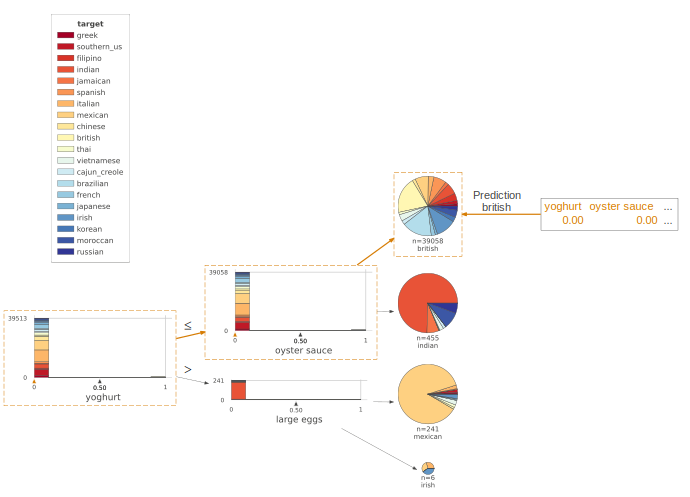

In [10]:
y_class_names = y_data.unique()
category_dict = {cont: id for id,cont in enumerate(y_class_names)}
y_int_data = y_data.replace(category_dict)

X_single = X_data.loc[np.random.randint(0, len(X_data)),:]  # random sample from training

viz = dtreeviz(model2.estimators_[20], X_data, y_int_data,
                target_name="target",
                feature_names=X_data.columns,
                class_names=list(y_class_names),
               orientation ='LR',  # left-right orientation
               X=X_single)  # need to give single observation for prediction
              
viz

##### 4.2.3 Variable importance

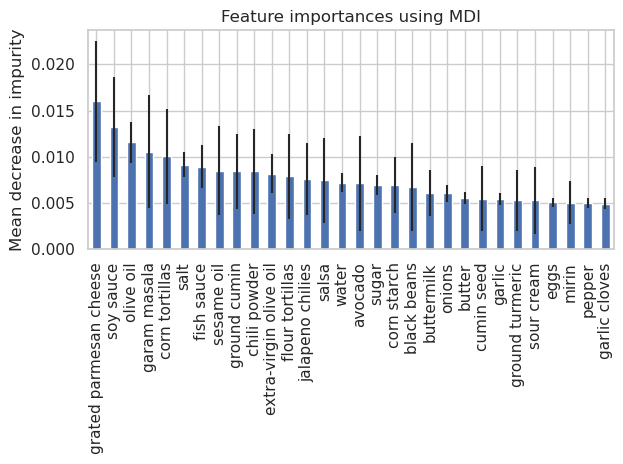

In [11]:
# variable importance MDI
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
df_importances = pd.DataFrame({"Importance": importances, "std": std}, index=X_data.columns).nlargest(30, columns="Importance")

fig, ax = plt.subplots()
df_importances["Importance"].plot.bar(yerr=df_importances["std"], ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

# Appendix

### A. Similarity of cuisines based on clustering

In [ ]:
df = pd.read_csv("Data/own_reduced_merged2.csv")
selected_data = df.drop(["cuisine", "Unnamed: 0", "ID"], axis=1)
clusters = shc.linkage(selected_data, 
            method='ward', 
            metric="euclidean")

shc.dendrogram(Z=clusters)

### B. Only un-impaired recipes

In [ ]:
aux.prepare_sparse_data_analysis_only_unimpaired(df_ingred, df_recipes)

In [12]:
# load data
X_data, y_data = aux.load_20_threshold_data_only_unimpaired()

# hold-back some test data
Xtrain, Xtest, y_train, y_test = train_test_split(X_data,y_data, test_size=0.2, random_state=101)

# fit the model under default parameters
model = RandomForestClassifier(n_estimators=50)
Xtrain, Xtest, y_train, y_test = train_test_split(X_data,y_data, test_size=0.2, random_state=101)
model.fit(Xtrain, y_train)
score = model.score(Xtest, y_test)

print(f"The RF prediction accuracy under sparse features and unimpaired recipes is: {score:.2f}")

The RF prediction accuracy under sparse features and unimpaired recipes is: 0.71
